In this Notebook I will show how to predict House Prices with MultiplayerPerceptron on Boston House Pirces dataset.

### Import

In [0]:
!pip install -q keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from keras.datasets import boston_housing

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import os
import random as rn
import numpy as np

# Randomness control
os.environ['PYTHONHASHSEED'] = '0'
RANDOM_SEED = 3939
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, 
                              inter_op_parallelism_threads=1)

tf.set_random_seed(RANDOM_SEED)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
keras.backend.set_session(sess)

### Constants

In [0]:
RANDOM_SEED = 3939

### Loading Data

MNIST data is being built into ``from keras.datasets`` module.

In [0]:
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

### Data Visualisation

Column descriptions:

    1. CRIM      per capita crime rate by town
    2. ZN        proportion of residential land zoned for lots over 
                 25,000 sq.ft.
    3. INDUS     proportion of non-retail business acres per town
    4. CHAS      Charles River dummy variable (= 1 if tract bounds 
                 river; 0 otherwise)
    5. NOX       nitric oxides concentration (parts per 10 million)
    6. RM        average number of rooms per dwelling
    7. AGE       proportion of owner-occupied units built prior to 1940
    8. DIS       weighted distances to five Boston employment centres
    9. RAD       index of accessibility to radial highways
    10. TAX      full-value property-tax rate per $10,000
11. PTRATIO  pupil-teacher ratio by town
12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks 
             by town
13. LSTAT    % lower status of the population
14. MEDV     Median value of owner-occupied homes in $1000's

In [0]:
feature_names = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", 
                 "RAD", "TAX", "PTRATIO", "B", "LSTAT"]
target = ["MEDV"]

In [22]:
def display_min_max(data, feature_names):
  for feature_i in range(data.shape[1]):
    print("Feature {}:".format(feature_names[feature_i]).ljust(20) 
          + "min: {}".format(data[:, feature_i].min()) .ljust(15) 
          + "| max: {}".format(data[:, feature_i].max()))
    
display_min_max(X_train, feature_names)

Feature CRIM:       min: 0.00632   | max: 88.9762
Feature ZN:         min: 0.0       | max: 100.0
Feature INDUS:      min: 0.46      | max: 27.74
Feature CHAS:       min: 0.0       | max: 1.0
Feature NOX:        min: 0.385     | max: 0.871
Feature RM:         min: 3.561     | max: 8.725
Feature AGE:        min: 2.9       | max: 100.0
Feature DIS:        min: 1.1296    | max: 10.7103
Feature RAD:        min: 1.0       | max: 24.0
Feature TAX:        min: 188.0     | max: 711.0
Feature PTRATIO:    min: 12.6      | max: 22.0
Feature B:          min: 0.32      | max: 396.9
Feature LSTAT:      min: 1.73      | max: 37.97


In [0]:
def display_draw_data(X, y, feature_names, target):
  row_num = 3
  col_num = 4
  f, ax = plt.subplots(row_num, col_num, figsize=(20,15))
  
  feature_i = 0
  for row in range(0, row_num):
    for col in range(0, col_num):
      feature_values = X[:, feature_i]
      ax[row, col].scatter(feature_values, y)
      ax[row, col].set_title("Price by {}".format(feature_names[feature_i]))
      ax[row, col].set_xlabel("{}".format(feature_names[feature_i]))
      ax[row, col].set_ylabel("{}".format(target[0]))
      feature_i += 1

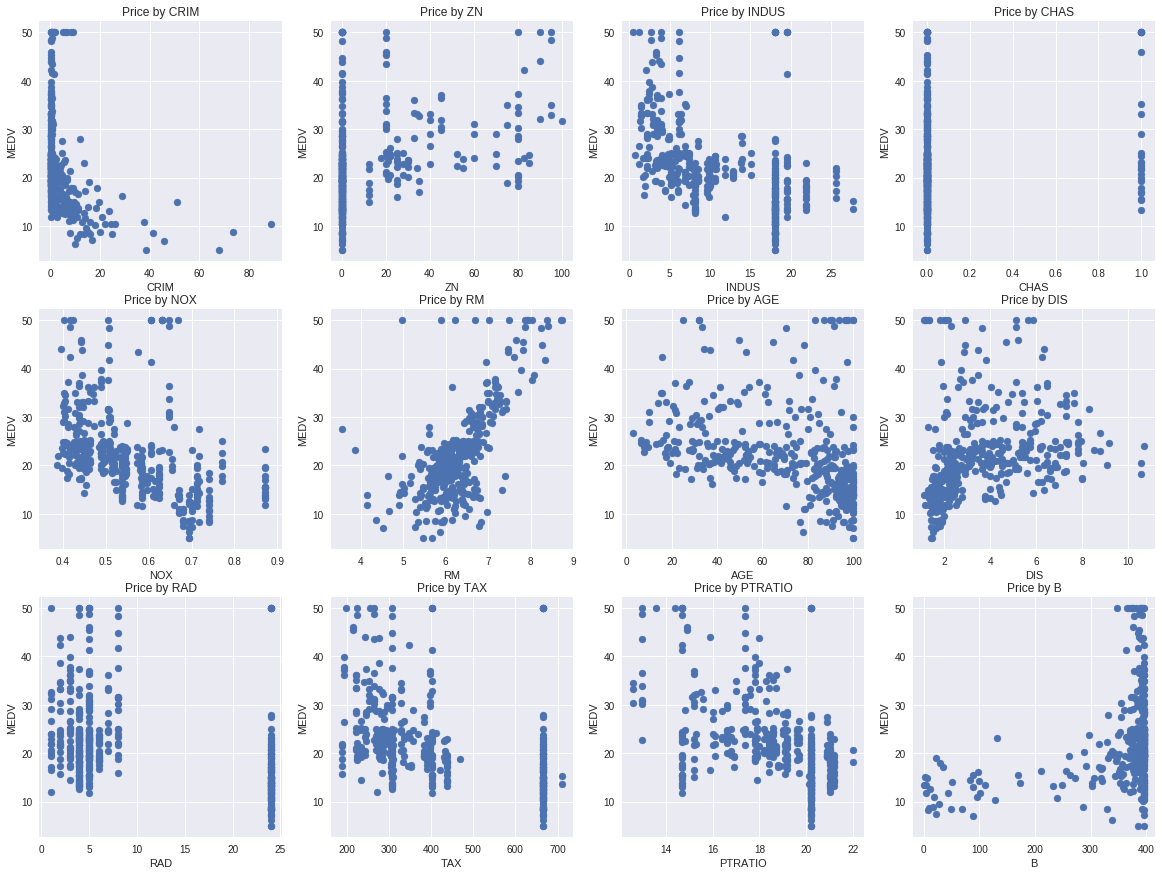

In [24]:
display_draw_data(X_train, y_train, feature_names, target)

### Data Preprocessing

Normalization

In [0]:
def normalize(X_train, X_test):
  merged = np.concatenate((X_train, X_test), axis=0)
  for feature_i in range(merged.shape[1]):
    feature = merged[:, feature_i]
    
    feature_mean = feature.mean()
    feature_std = feature.std()
    
    merged[:, feature_i] = (merged[:, feature_i] - feature_mean) / feature_std
    
  return merged[:X_train.shape[0]], merged[X_train.shape[0]:]

X_train_norm, X_test_norm = normalize(X_train, X_test)

Data after normalization:

In [26]:
display_min_max(X_train_norm, feature_names)

Feature CRIM:       min: -0.41978193864600827| max: 9.933930601860267
Feature ZN:         min: -0.48772236467012914| max: 3.8042344444270078
Feature INDUS:      min: -1.5578417886292544| max: 2.4225651639322434
Feature CHAS:       min: -0.27259856706992697| max: 3.668397859712446
Feature NOX:        min: -1.4658819321902887| max: 2.732346478414959
Feature RM:         min: -3.880249360477939| max: 3.4766880429269578
Feature AGE:        min: -2.3354370442030166| max: 1.1174944851594597
Feature DIS:        min: -1.2670691948547694| max: 3.2872999127421076
Feature RAD:        min: -0.9828428567665056| max: 1.6612452539705709
Feature TAX:        min: -1.3080507609049026| max: 1.7981941894212963
Feature PTRATIO:    min: -2.70737911111876| max: 1.6388283221814757
Feature B:          min: -3.907193304981041| max: 0.4410519326070331
Feature LSTAT:      min: -1.5311271005308111| max: 3.548770808914468


In [27]:
display_min_max(X_test_norm, feature_names)

Feature CRIM:       min: -0.4189917643965877| max: 2.4941782037922886
Feature ZN:         min: -0.48772236467012914| max: 3.375038763517294
Feature INDUS:      min: -1.4469506858452832| max: 2.4225651639322434
Feature CHAS:       min: -0.27259856706992697| max: 3.668397859712446
Feature NOX:        min: -1.4054136217494724| max: 2.732346478414959
Feature RM:         min: -2.0011245666957818| max: 3.5550442701127185
Feature AGE:        min: -2.22519927138094| max: 1.1174944851594597
Feature DIS:        min: -1.1073927011495295| max: 3.9605176870361256
Feature RAD:        min: -0.9828428567665056| max: 1.6612452539705709
Feature TAX:        min: -1.3139900437927154| max: 1.7981941894212963
Feature PTRATIO:    min: -2.5224341139570474| max: 1.268938327858051
Feature B:          min: -3.640430466132592| max: 0.4410519326070331
Feature LSTAT:      min: -1.5044940816899004| max: 2.7105315843426476


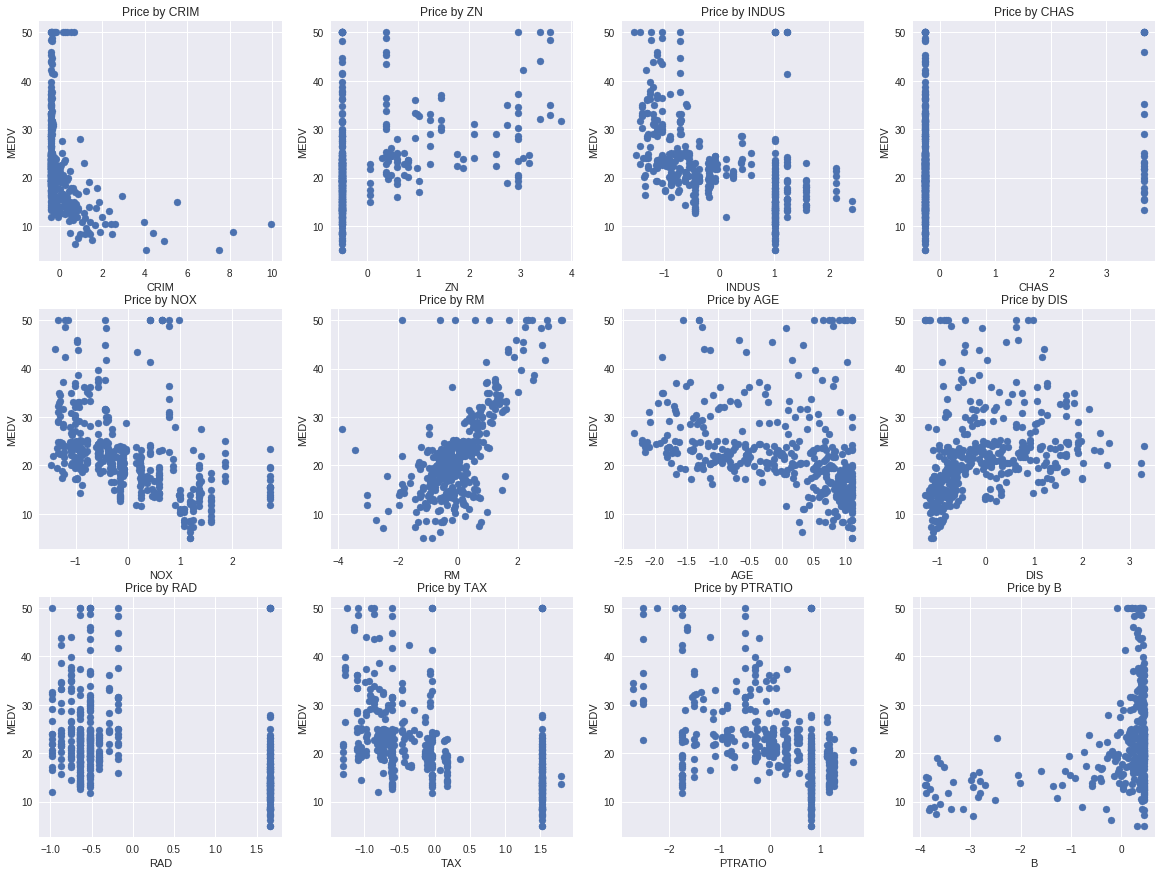

In [28]:
display_draw_data(X_train_norm, y_train, feature_names, target)

### Train/Validation data split

In [29]:
split_ratio = 0.8
split_index = int(X_train.shape[0] * split_ratio)

X_train_input, y_train_input = X_train_norm[:split_index], y_train[:split_index]
X_val_input, y_val_input = X_train_norm[split_index:], y_train[split_index:]

print("X_train_input shape: {}".format(X_train_input.shape))
print("y_train_input shape: {}".format(y_train_input.shape))
print("X_val_input shape: {}".format(X_val_input.shape))
print("y_val_input shape: {}".format(y_val_input.shape))

X_train_input shape: (323, 13)
y_train_input shape: (323,)
X_val_input shape: (81, 13)
y_val_input shape: (81,)


### Model

Creation

In [30]:
feature_num = X_train_input.shape[1]

model = Sequential()
model.add(Dense(64, 
                activation="relu", 
                input_shape=(feature_num,), 
                kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
model.add(Dense(1, activation="linear")) 
    
model.compile(loss="mean_squared_error", optimizer=Adam(0.06))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


Training

In [31]:
history = model.fit(X_train_input, y_train_input,
                    batch_size=32,
                    epochs=70,
                    verbose=2,
                    validation_data=(X_val_input, y_val_input))

Train on 323 samples, validate on 81 samples
Epoch 1/70
 - 0s - loss: 255.7273 - val_loss: 60.1056
Epoch 2/70
 - 0s - loss: 50.9323 - val_loss: 25.1344
Epoch 3/70
 - 0s - loss: 30.2842 - val_loss: 29.6788
Epoch 4/70
 - 0s - loss: 20.0264 - val_loss: 20.4282
Epoch 5/70
 - 0s - loss: 12.7146 - val_loss: 14.2098
Epoch 6/70
 - 0s - loss: 11.2719 - val_loss: 14.2520
Epoch 7/70
 - 0s - loss: 12.3547 - val_loss: 15.4467
Epoch 8/70
 - 0s - loss: 12.1027 - val_loss: 12.0721
Epoch 9/70
 - 0s - loss: 11.0595 - val_loss: 19.0970
Epoch 10/70
 - 0s - loss: 10.7937 - val_loss: 13.3832
Epoch 11/70
 - 0s - loss: 11.0552 - val_loss: 13.8815
Epoch 12/70
 - 0s - loss: 13.3219 - val_loss: 16.3670
Epoch 13/70
 - 0s - loss: 11.5304 - val_loss: 17.8570
Epoch 14/70
 - 0s - loss: 11.1075 - val_loss: 10.8090
Epoch 15/70
 - 0s - loss: 8.4870 - val_loss: 11.5129
Epoch 16/70
 - 0s - loss: 7.8973 - val_loss: 9.7686
Epoch 17/70
 - 0s - loss: 7.8151 - val_loss: 11.9522
Epoch 18/70
 - 0s - loss: 7.7568 - val_loss: 9.94

Epoch 44/70
 - 0s - loss: 6.1354 - val_loss: 10.2952
Epoch 45/70
 - 0s - loss: 6.8141 - val_loss: 11.3885
Epoch 46/70
 - 0s - loss: 6.5562 - val_loss: 8.9190
Epoch 47/70
 - 0s - loss: 6.5988 - val_loss: 7.8186
Epoch 48/70
 - 0s - loss: 5.7237 - val_loss: 8.6865
Epoch 49/70
 - 0s - loss: 7.3328 - val_loss: 12.3482
Epoch 50/70
 - 0s - loss: 7.9791 - val_loss: 11.2468
Epoch 51/70
 - 0s - loss: 7.1330 - val_loss: 12.2085
Epoch 52/70
 - 0s - loss: 5.9867 - val_loss: 9.0512
Epoch 53/70
 - 0s - loss: 5.4784 - val_loss: 11.8770
Epoch 54/70
 - 0s - loss: 10.3215 - val_loss: 13.7063
Epoch 55/70
 - 0s - loss: 9.5184 - val_loss: 13.1173
Epoch 56/70
 - 0s - loss: 7.5779 - val_loss: 9.1833
Epoch 57/70
 - 0s - loss: 7.8976 - val_loss: 11.2061
Epoch 58/70
 - 0s - loss: 6.8880 - val_loss: 10.5577
Epoch 59/70
 - 0s - loss: 6.1661 - val_loss: 7.9230
Epoch 60/70
 - 0s - loss: 5.6222 - val_loss: 10.9007
Epoch 61/70
 - 0s - loss: 5.6985 - val_loss: 9.8163
Epoch 62/70
 - 0s - loss: 5.4830 - val_loss: 8.2603


Training details

In [32]:
score = model.evaluate(X_test_norm, y_test)
print("Train MSE: {}".format(score))

102/102 [==============================] - 0s 144us/step
Train MSE: 15.330325556736366


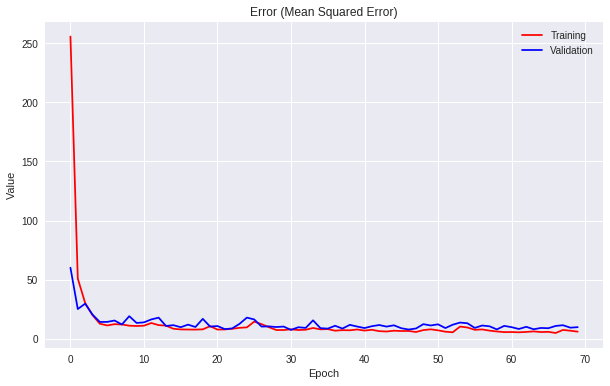

In [33]:
f, ax = plt.subplots()
f.set_size_inches(10, 6)
    
ax.plot(history.history["loss"], c="r")
ax.plot(history.history["val_loss"], c="b")
ax.set_title("Error (Mean Squared Error)")
ax.set_ylabel("Value")
ax.set_xlabel("Epoch")
ax.legend(["Training", "Validation"], loc="best");

Prediction

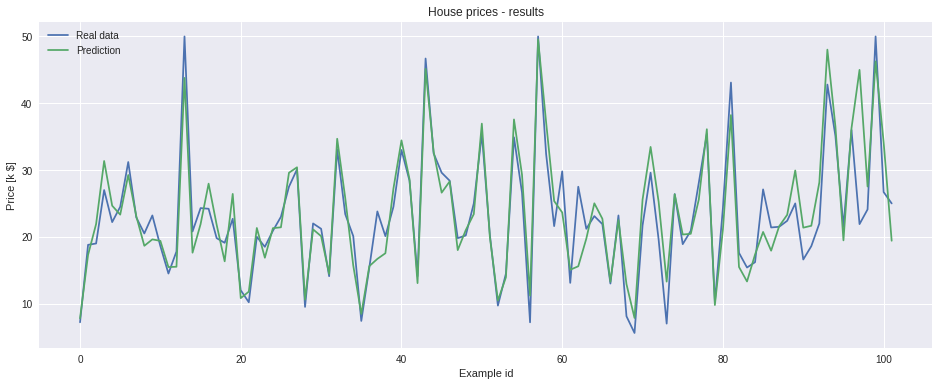

In [34]:
predictions = model.predict(X_test_norm)

plt.figure(figsize=(16,6))
plt.plot(np.arange(0, len(y_test), 1), y_test)
plt.plot(np.arange(0, len(y_test), 1), predictions)
plt.title("House prices - results")
plt.ylabel("Price [k $]")
plt.xlabel("Example id")
plt.legend(["Real data", "Prediction"]);